# 🤖 Prédiction de retours boursiers (ML)

## Objectif
- Prédire si le prix va monter ou descendre demain.
- Utiliser des features techniques
- Modèles : Random Forest, Réseau de neuronnes (RNN)

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os

LIMITE_FILES = 10

sources = os.listdir("../1-data-collection/csv/")
sources = [source for source in sources if source.endswith('.csv')][:LIMITE_FILES]
for source in sources:
    data = pd.read_csv(f"../1-data-collection/csv/{source}", index_col=0, parse_dates=True)

    data['return_1d'] = data['Close'].pct_change()
    data['MA10'] = data['Close'].rolling(10).mean()
    data['MA50'] = data['Close'].rolling(50).mean()
    data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data = data.dropna()

    X = data[['return_1d', 'MA10', 'MA50']]
    y = data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.45      0.89      0.59       218
           1       0.59      0.13      0.21       276

    accuracy                           0.46       494
   macro avg       0.52      0.51      0.40       494
weighted avg       0.53      0.46      0.38       494

              precision    recall  f1-score   support

           0       0.48      0.63      0.54       235
           1       0.53      0.38      0.44       259

    accuracy                           0.50       494
   macro avg       0.50      0.50      0.49       494
weighted avg       0.50      0.50      0.49       494

              precision    recall  f1-score   support

           0       0.55      0.38      0.45        94
           1       0.55      0.70      0.61       100

    accuracy                           0.55       194
   macro avg       0.55      0.54      0.53       194
weighted avg       0.55      0.55      0.53       194

              preci

## Application d'un RNN

Première approche : 
- En entrée on a le jour $x_n$ et en sortie le jour $x_{n+1}$
- Objectif :
    - prédire le jour suivant à l'aide du jour précédent
- Hypothèses de problemes en amont :
    - un jour peut ne pas être suffisant pour prédire l'évolution du marché au jour $x_{n + 1}$

Deuxième approche :
- Ajouter une technique d'analyse de sentiment (lstm) sur l'actualité (-1 Négatif max / +1 positif max)
- Objetif :
    - La bourse dépends de l'actualité également donc celà ne sera que bénéfique pour le modèle
- Hypothèses de problèmes en amont :
    - Récupérer les actus sur le long terme est compliqué
    - Devoir faire matcher différents site de news car certains peuvent être biaisé ou se trompent
    - ATTENTION AUX NEWS PROPRIETAIRE ET VERIFIER A QUI ELLE APPARTIENT

Open         2.784750e+01
High         2.786000e+01
Low          2.683750e+01
Close        2.733250e+01
Adj Close    2.428858e+01
Volume       2.128184e+08
Name: 2015-01-02 00:00:00, dtype: float64
X: 2514, y: 2514
X_scaled: (2514, 6)
y_scaled: (2514, 6)
Epoch [10/100], Loss: 0.5261
Epoch [20/100], Loss: 0.3546
Epoch [30/100], Loss: 0.2308
Epoch [40/100], Loss: 0.1513
Epoch [50/100], Loss: 0.1103
Epoch [60/100], Loss: 0.0932
Epoch [70/100], Loss: 0.0862
Epoch [80/100], Loss: 0.0827
Epoch [90/100], Loss: 0.0809
Epoch [100/100], Loss: 0.0800
Test Loss: 0.0309
Predictions: (503, 6)


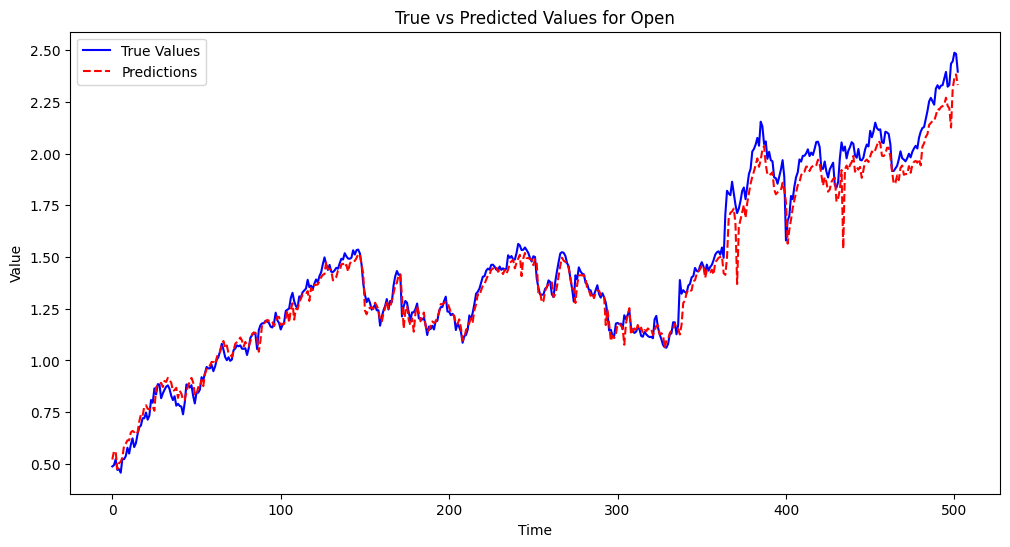

Accuracy for dimension 0: 0.99
RMSE for dimension 0: 0.0892


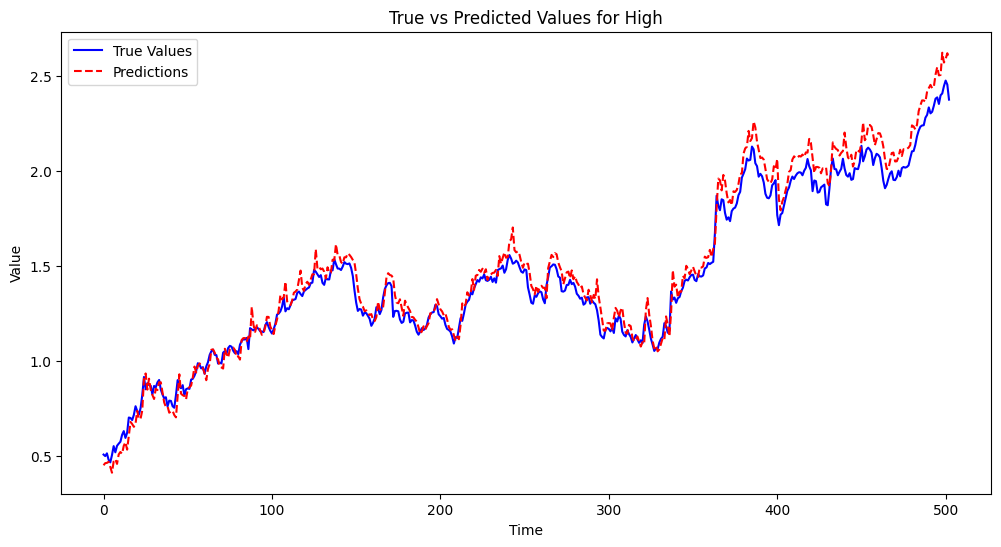

Accuracy for dimension 1: 0.99
RMSE for dimension 1: 0.1092


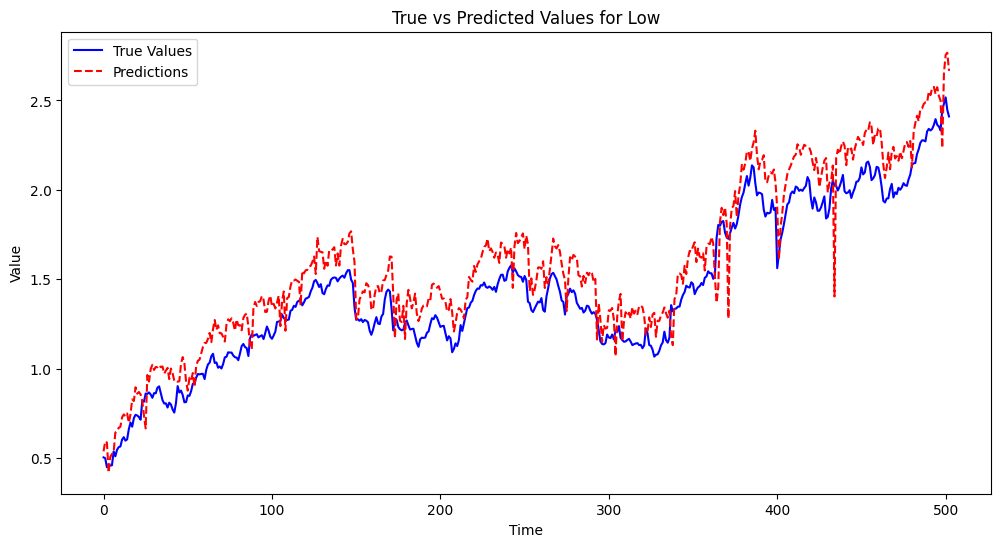

Accuracy for dimension 2: 0.99
RMSE for dimension 2: 0.0892


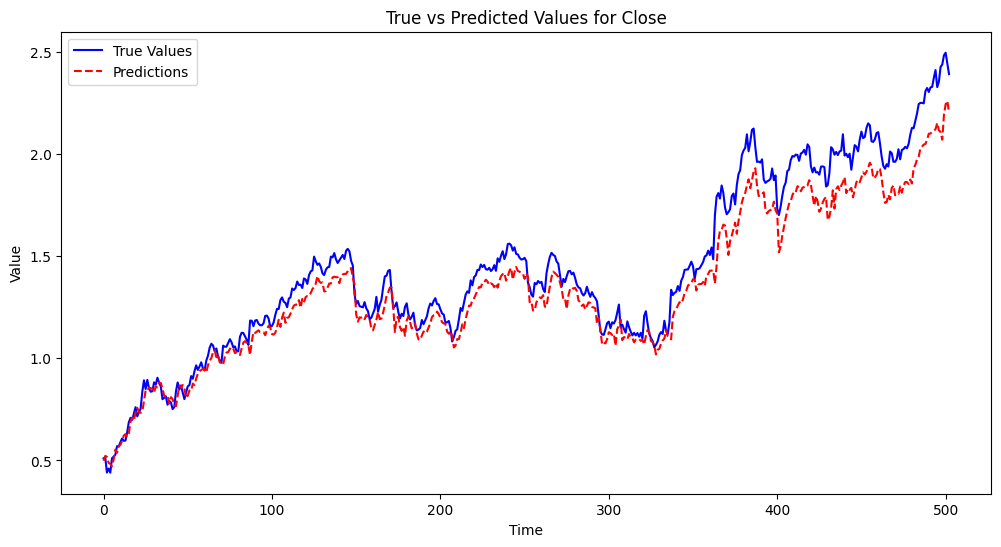

Accuracy for dimension 3: 0.99
RMSE for dimension 3: 0.0772


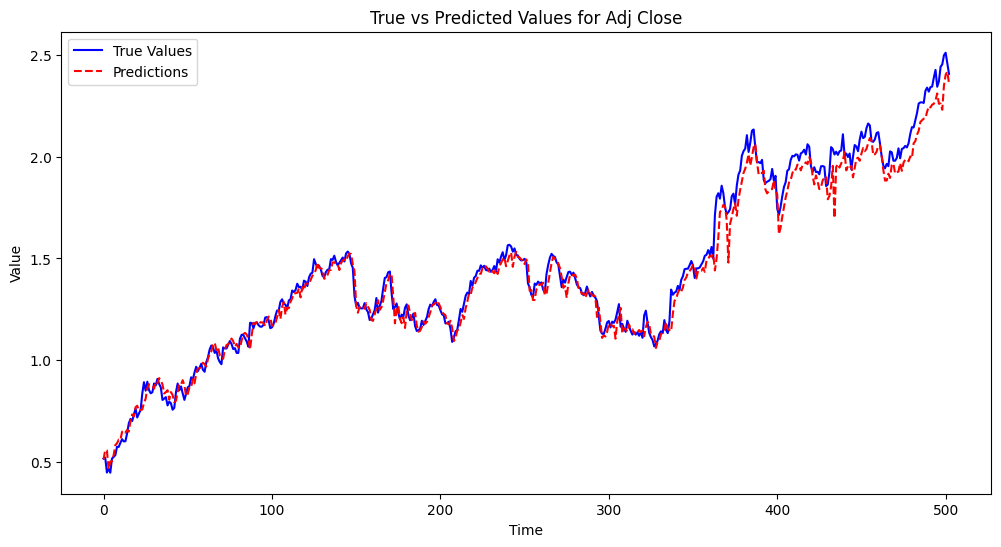

Accuracy for dimension 4: 1.00
RMSE for dimension 4: 0.0631


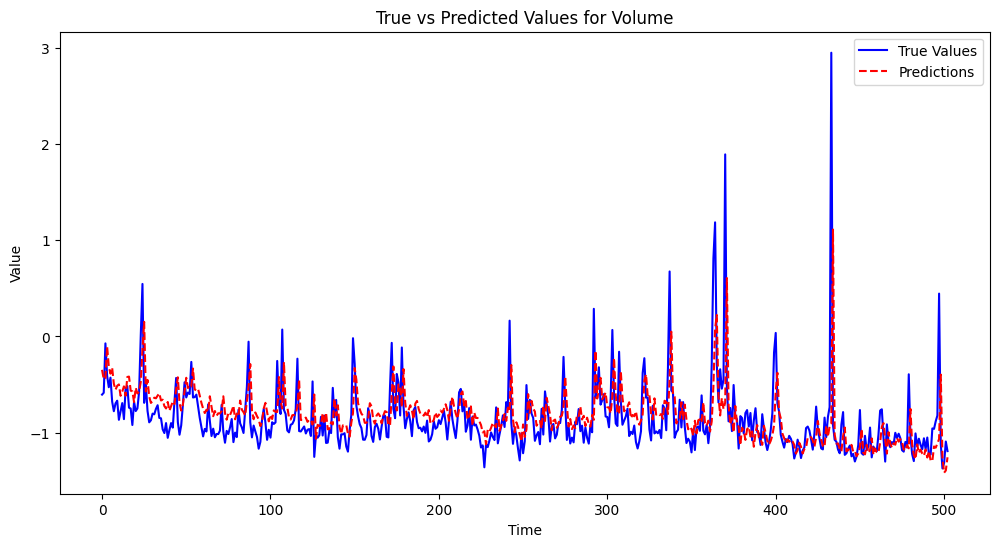

Accuracy for dimension 5: 0.98
RMSE for dimension 5: 0.1261
Global Accuracy: 0.99


In [2]:
# Première apporche RNN x_n -> x_n+1

data = pd.read_csv(f"../1-data-collection/csv/{sources[0]}", index_col=0, parse_dates=True)

print(data.iloc[0])  # Affiche la première ligne

def prepare_data(data: pd.DataFrame):
    return [(data.iloc[i], data.iloc[i + 1]) for i in range(len(data) - 1)]

X, y = zip(*prepare_data(data))
print(f"X: {len(X)}, y: {len(y)}")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"X_scaled: {X_scaled.shape}") # (2514, 6)
y_scaled = scaler.fit_transform(y)
print(f"y_scaled: {y_scaled.shape}") # (2514, 6)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

import torch
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
input_size = X_train.shape[1]
hidden_size = 64
output_size = y_train.shape[1]
model = MLP(input_size, hidden_size, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def train(model, X_train, y_train, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
train(model, X_train, y_train, criterion, optimizer, epochs=100)
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32)
        targets = torch.tensor(y_test, dtype=torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print(f"Test Loss: {loss.item():.4f}")
evaluate(model, X_test, y_test)
def predict(model, X):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = model(inputs)
        return outputs.numpy()
predictions = predict(model, X_test)
print(f"Predictions: {predictions.shape}")  # (502, 6)

import matplotlib.pyplot as plt
def plot_predictions(y_true, y_pred, dim, name_dim='Dimension'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, dim], label='True Values', color='blue')
    plt.plot(y_pred[:, dim], label='Predictions', color='red', linestyle='--')
    plt.title('True vs Predicted Values for {}'.format(name_dim))
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
for dim in range(y_test.shape[1]):
    plot_predictions(y_test, predictions, dim, name_dim=data.columns[dim])
    # Accuracy
    predictions[:, dim] = (predictions[:, dim] > 0.5).astype(int)
    y_test[:, dim] = (y_test[:, dim] > 0.5).astype(int)
    accuracy = (predictions[:, dim] == y_test[:, dim]).mean()
    print(f"Accuracy for dimension {dim}: {accuracy:.2f}")
    # RMSE
    rmse = ((predictions[:, dim] - y_test[:, dim]) ** 2).mean() ** 0.5
    print(f"RMSE for dimension {dim}: {rmse:.4f}")

# Accuracy globale
accuracy_global = (predictions == y_test).mean()
print(f"Global Accuracy: {accuracy_global:.2f}")

## Predire la valeur de fermeture du jour $x_{n+1}$
- à partir des ouverture (et fermetures ?) des jours précédents

Epoch 0, Loss: 10317.946289
Epoch 100, Loss: 8752.433594
Epoch 200, Loss: 7719.927246
Epoch 300, Loss: 6809.476562
Epoch 400, Loss: 6006.220703
Epoch 500, Loss: 5300.103027
Epoch 600, Loss: 4682.541016
Epoch 700, Loss: 4145.673828
Epoch 800, Loss: 3682.111084
Epoch 900, Loss: 3276.741943
Epoch 1000, Loss: 2890.550781
Epoch 1100, Loss: 2561.151855
Epoch 1200, Loss: 2272.607422
Epoch 1300, Loss: 2018.846436
Epoch 1400, Loss: 1792.959473
Epoch 1500, Loss: 1590.213623
Epoch 1600, Loss: 1407.783447
Epoch 1700, Loss: 1243.235718
Epoch 1800, Loss: 1094.894775
Epoch 1900, Loss: 961.447632
Epoch 2000, Loss: 841.675964
Epoch 2100, Loss: 734.706299
Epoch 2200, Loss: 639.748291
Epoch 2300, Loss: 555.658386
Epoch 2400, Loss: 481.543274
Epoch 2500, Loss: 416.607361
Epoch 2600, Loss: 359.952179
Epoch 2700, Loss: 310.865601
Epoch 2800, Loss: 268.454895
Epoch 2900, Loss: 232.028732
Epoch 3000, Loss: 200.901077
Epoch 3100, Loss: 174.265945
Epoch 3200, Loss: 151.438644
Epoch 3300, Loss: 131.922974
Epoch 

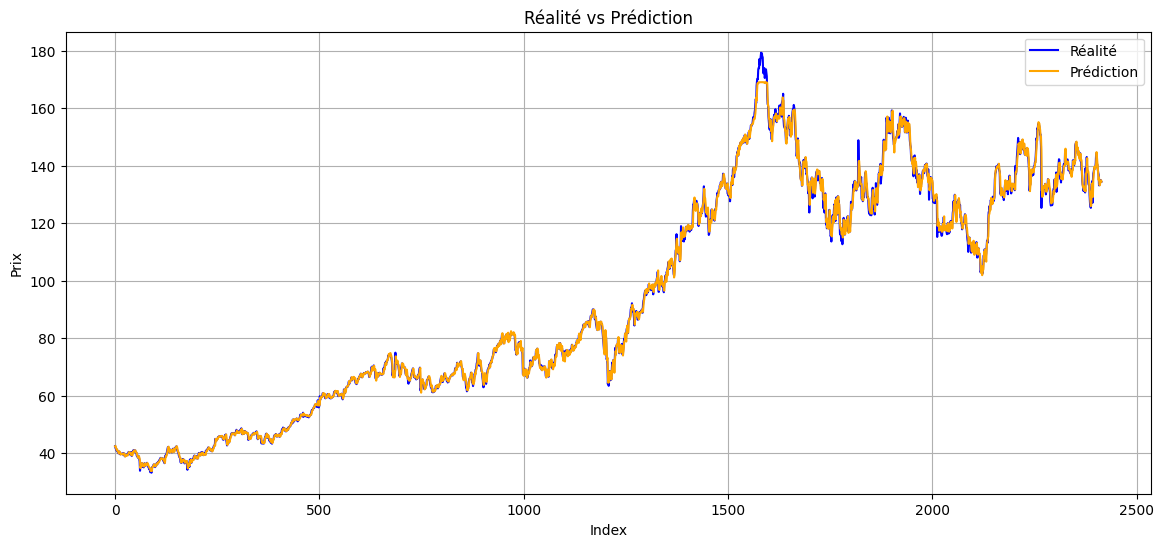

Prix actuel : 134.40
Prix prédit : 134.26 (-0.11%)
Décision : Conserver 🤝


In [32]:
import numpy as np
import torch

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

import torch.nn as nn

class RNNPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(RNNPredictor, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)  # output shape: (batch, seq_len, hidden_size)
        last_output = output[:, -1, :]  # on ne garde que la dernière sortie
        return self.fc(last_output)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def step(self, loss):
        if self.best_loss is None or loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
        return False  # Continue training

def train(model, X, y, epochs=1000, lr=0.001, verbose=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=100, min_delta=0.0001)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        if early_stopping.step(loss.item()):
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

data = pd.read_csv(f"../1-data-collection/csv/A_data.csv", index_col=0, parse_dates=True)
open_prices = data["Open"].values

window_size = 100  # nombre de pas de temps en entrée
X, y = create_sequences(open_prices, window_size)

# Conversion en tenseurs PyTorch
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, 1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (batch, 1)

cuda = torch.cuda.is_available()
if cuda:
    X = X.cuda()
    y = y.cuda()

model = RNNPredictor(input_size=1, hidden_size=64, output_size=1)
if cuda:
    model = model.cuda()

train(model, X, y, epochs=10000, lr=0.001)

# Prédire la prochaine valeur après la dernière séquence
last_sequence = open_prices[-window_size:]
last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_len, 1)
if cuda:
    last_sequence_tensor = last_sequence_tensor.cuda()
model.eval()
with torch.no_grad():
    next_value = model(last_sequence_tensor).item()
# Afficher la dernière valeur et la valeur prédite
print(f"Dernière valeur : {last_sequence[-1]:.2f}, Valeur prédite : {next_value:.2f}")
# Visualiser les prédictions

import matplotlib.pyplot as plt

def plot_predictions(model, X, y_true, title="Réalité vs Prédiction"):
    model.eval()
    with torch.no_grad():
        y_pred = model(X).cpu().numpy().flatten()
    y_true = y_true.cpu().numpy().flatten()
    
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label="Réalité", color='blue')
    plt.plot(y_pred, label="Prédiction", color='orange')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(model, X, y)

def trading_decision(model, data, window_size):
    model.eval()
    recent_sequence = data[-window_size:]
    input_tensor = torch.tensor(recent_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    if cuda:
        input_tensor = input_tensor.cuda()
    with torch.no_grad():
        predicted_price = model(input_tensor).item()
    
    last_price = data[-1]
    diff = predicted_price - last_price
    percent_change = (diff / last_price) * 100

    print(f"Prix actuel : {last_price:.2f}")
    print(f"Prix prédit : {predicted_price:.2f} ({percent_change:+.2f}%)")

    if percent_change > 0.5:
        return "Acheter ✅"
    elif percent_change < -0.5:
        return "Vendre ❌"
    else:
        return "Conserver 🤝"

decision = trading_decision(model, open_prices, window_size=100)
print("Décision :", decision)


### Entrainement avec plusierus datasets

In [26]:
sources = os.listdir("../1-data-collection/csv/")
sources = [source for source in sources if source.endswith('.csv')][:LIMITE_FILES]
for source in sources:
    data = pd.read_csv(f"../1-data-collection/csv/{source}", index_col=0, parse_dates=True)
    open_prices = data["Open"].values
    window_size = 100  # nombre de pas de temps en entrée
    X, y = create_sequences(open_prices, window_size)
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, 1)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (batch, 1)
    if cuda:
        X = X.cuda()
        y = y.cuda()
    # model = RNNPredictor(input_size=1, hidden_size=64, output_size=1)
    # if cuda:
    #     model = model.cuda()
    train(model, X, y, epochs=10000, lr=0.001, verbose=False)
    last_sequence = open_prices[-window_size:]
    last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_len, 1)
    if cuda:
        last_sequence_tensor = last_sequence_tensor.cuda()
    model.eval()
    with torch.no_grad():
        next_value = model(last_sequence_tensor).item()
    print(f"{source} - Dernière valeur : {last_sequence[-1]:.2f}, Valeur prédite : {next_value:.2f}")
    decision = trading_decision(model, open_prices, window_size=100)
    print(f"{source} - Décision : {decision}")

AAPL_data.csv - Dernière valeur : 252.23, Valeur prédite : 237.80
Prix actuel : 252.23
Prix prédit : 237.80 (-5.72%)
AAPL_data.csv - Décision : Vendre ❌
ABBV_data.csv - Dernière valeur : 177.02, Valeur prédite : 176.44
Prix actuel : 177.02
Prix prédit : 176.44 (-0.33%)
ABBV_data.csv - Décision : Conserver 🤝
ABNB_data.csv - Dernière valeur : 131.31, Valeur prédite : 130.55
Prix actuel : 131.31
Prix prédit : 130.55 (-0.58%)
ABNB_data.csv - Décision : Vendre ❌
ABT_data.csv - Dernière valeur : 114.13, Valeur prédite : 113.28
Prix actuel : 114.13
Prix prédit : 113.28 (-0.75%)
ABT_data.csv - Décision : Vendre ❌
ACGL_data.csv - Dernière valeur : 91.78, Valeur prédite : 92.21
Prix actuel : 91.78
Prix prédit : 92.21 (+0.47%)
ACGL_data.csv - Décision : Conserver 🤝
ACN_data.csv - Dernière valeur : 352.61, Valeur prédite : 349.82
Prix actuel : 352.61
Prix prédit : 349.82 (-0.79%)
ACN_data.csv - Décision : Vendre ❌
ADBE_data.csv - Dernière valeur : 442.94, Valeur prédite : 444.00
Prix actuel : 442.

Epoch 0 - Loss: 10515.698242
Epoch 10 - Loss: 9589.013672
Epoch 20 - Loss: 9438.776367
Epoch 30 - Loss: 9314.995117
Epoch 40 - Loss: 9185.403320
Epoch 50 - Loss: 9049.158203
Epoch 60 - Loss: 8905.326172
Epoch 70 - Loss: 8753.922852
Epoch 80 - Loss: 8595.145508
Epoch 90 - Loss: 8429.553711
Epoch 100 - Loss: 8257.091797
Epoch 110 - Loss: 8077.943848
Epoch 120 - Loss: 7893.328613
Epoch 130 - Loss: 7703.291016
Epoch 140 - Loss: 7508.400879
Epoch 150 - Loss: 7309.807129
Epoch 160 - Loss: 7107.191895
Epoch 170 - Loss: 6901.643555
Epoch 180 - Loss: 6694.299805
Epoch 190 - Loss: 6485.225098
Epoch 200 - Loss: 6275.352051
Epoch 210 - Loss: 6065.375488
Epoch 220 - Loss: 5855.798828
Epoch 230 - Loss: 5647.357422
Epoch 240 - Loss: 5440.659668
Epoch 250 - Loss: 5236.450195
Epoch 260 - Loss: 5035.087402
Epoch 270 - Loss: 4837.436035
Epoch 280 - Loss: 4643.709473
Epoch 290 - Loss: 4454.235352
Epoch 300 - Loss: 4270.136230
Epoch 310 - Loss: 4091.153564
Epoch 320 - Loss: 3917.812012
Epoch 330 - Loss: 37

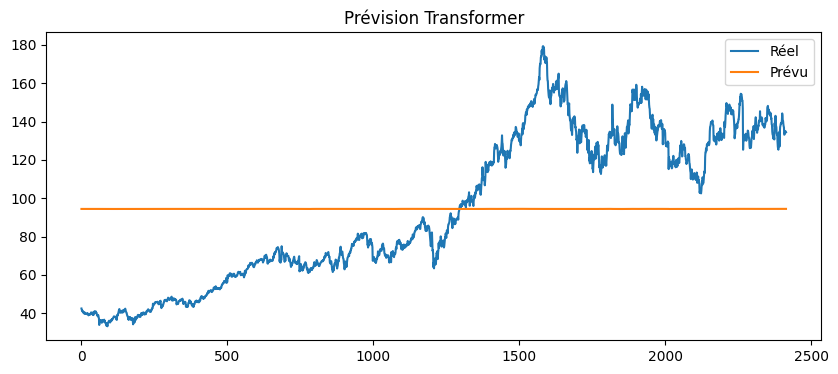

Prix actuel : 134.62 | Prévu : 94.44
Décision : VENDRE


In [31]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=3, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.seq_len = seq_len
        self.input_proj = nn.Linear(1, d_model)  # univarié → embedding
        self.positional_encoding = self._generate_positional_encoding(seq_len, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=dropout, batch_first=True)
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def _generate_positional_encoding(self, seq_len, d_model):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # shape: (1, seq_len, d_model)

    def forward(self, x):  # x shape: (batch_size, seq_len, 1)
        x = self.input_proj(x) + self.positional_encoding.to(x.device)
        x = self.transformer_encoder(x)
        return self.decoder(x[:, -1, :])  # prédiction à partir du dernier token encodé

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return torch.tensor(X).float().unsqueeze(-1), torch.tensor(y).float().unsqueeze(-1)

def train_model(model, X, y, epochs=100, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item():.6f}")

import matplotlib.pyplot as plt

def plot_prediction(model, X, y, title="Prévision Transformer", cuda=False):
    model.eval()
    with torch.no_grad():
        if cuda:
            X = X.cuda()
            y = y.cuda()
        preds = model(X).cpu().numpy().flatten()
    if cuda:
        y = y.cpu()
    preds = preds.squeeze()
    y_true = y.numpy().flatten()
    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label='Réel')
    plt.plot(preds, label='Prévu')
    plt.title(title)
    plt.legend()
    plt.show()

def trading_decision(current_price, predicted_price, seuil=0.01):
    delta = (predicted_price - current_price) / current_price
    if delta > seuil:
        return "ACHETER"
    elif delta < -seuil:
        return "VENDRE"
    else:
        return "NE RIEN FAIRE"

# Exemple de série synthétique ou importée
import numpy as np

data = pd.read_csv(f"../1-data-collection/csv/A_data.csv", index_col=0, parse_dates=True)
open_prices = data["Open"].values
seq_len = 100  # Longueur de la séquence
X, y = create_sequences(open_prices, seq_len)

cuda = torch.cuda.is_available()
if cuda:
    X = X.cuda()
    y = y.cuda()

model = TimeSeriesTransformer(seq_len=seq_len)
if cuda:
    model = model.cuda()
train_model(model, X, y, epochs=1000, lr=1e-3)

plot_prediction(model, X, y, title="Prévision Transformer", cuda=cuda)

# Exemple de décision
current_price = X[-1, -1, 0].item()
predicted_price = model(X[-1:].float()).item()
print(f"Prix actuel : {current_price:.2f} | Prévu : {predicted_price:.2f}")
print(f"Décision : {trading_decision(current_price, predicted_price)}")
